<a href="https://colab.research.google.com/github/TanyaSri-23/AvengersFaceDetection/blob/main/AvengersFaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [69]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path = Path("/content/drive/MyDrive/images/train")
val_path = Path("/content/drive/MyDrive/images/val")
test_path = Path("/content/drive/MyDrive/images/test")

In [4]:
train_image= list((train_path.glob("**/*.png")))
test_image= list((test_path.glob("**/*.png")))
val_image= list((val_path.glob("**/*.png")))
# train_image= list(str(train_path.glob("**/*.png")))
# test_image= list(str(test_path.glob("**/*.png")))
# val_image= list(str(val_path.glob("**/*.png")))
# train_image[0].split("/")[-2]

In [5]:
def labels(filepath):
    label =[]
    for i in range (0, (len(filepath))):
        label1=str(filepath[i]).split("/")[-2]
        label.append(label1)
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(label, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    return df
    

In [6]:
train_df = labels(train_image)
test_df = labels(test_image)
val_df = labels(val_image)
train_df.head(5)


,Filepath,Label
0,/content/drive/MyDrive/images/train/mark_ruffa...,mark_ruffalo
1,/content/drive/MyDrive/images/train/chris_hems...,chris_hemsworth
2,/content/drive/MyDrive/images/train/robert_dow...,robert_downey_jr
3,/content/drive/MyDrive/images/train/scarlett_j...,scarlett_johansson
4,/content/drive/MyDrive/images/train/scarlett_j...,scarlett_johansson


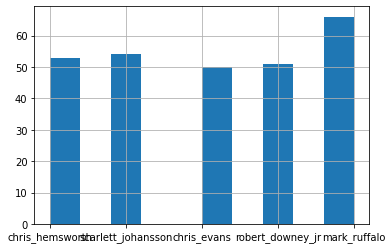

In [62]:
train_df["Label"].hist()

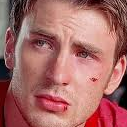

In [7]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
img = image.load_img(train_image[2])
img

In [25]:
train_df=train_df.sample(frac=1)
test_df=test_df.sample(frac=1)
val_df=val_df.sample(frac=1)



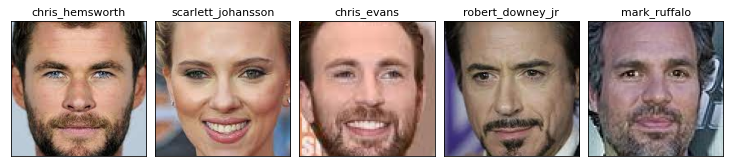

In [26]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
print(axes.flat)


for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 11)
plt.tight_layout(pad=0.2)
plt.show()

In [27]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [28]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 274 validated image filenames belonging to 5 classes.


In [29]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 60 validated image filenames belonging to 5 classes.


In [30]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 60 validated image filenames belonging to 5 classes.


In [31]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
#pretrained_model.add(tf.keras.layers.Dense(12, activation = 'softmax'))

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
train_images

In [34]:
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
9/9 [==============================] - 95s 11s/step - loss: 1.5975 - accuracy: 0.2993 - val_loss: 1.2503 - val_accuracy: 0.5333
Epoch 2/5
9/9 [==============================] - 11s 1s/step - loss: 1.2074 - accuracy: 0.5730 - val_loss: 0.9261 - val_accuracy: 0.7333
Epoch 3/5
9/9 [==============================] - 11s 1s/step - loss: 0.8943 - accuracy: 0.7044 - val_loss: 0.7082 - val_accuracy: 0.7667
Epoch 4/5
9/9 [==============================] - 11s 1s/step - loss: 0.6109 - accuracy: 0.8358 - val_loss: 0.3640 - val_accuracy: 0.9833
Epoch 5/5
9/9 [==============================] - 11s 1s/step - loss: 0.4294 - accuracy: 0.9124 - val_loss: 0.2483 - val_accuracy: 0.9833


In [35]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1[9]

2/2 [==============================] - 9s 7s/step


'mark_ruffalo'

In [ ]:
pred1

In [39]:
Y_test = test_df["Label"].to_numpy()

In [40]:
c=0
for i in range (0, len(pred1)):
  if (pred1[i]==Y_test[i]):

    c=c+1

In [44]:
(c/len(pred1))*100

98.33333333333333

In [47]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array


In [45]:
model.save('Avengers.h5')

In [48]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [51]:
output(r"/content/b.jpg")

1/1 [==============================] - 0s 82ms/step


'robert_downey_jr'

In [53]:
output(r"/content/drive/MyDrive/images/test/scarlett_johansson/scarlett_johansson25.png")

1/1 [==============================] - 0s 103ms/step


'scarlett_johansson'

In [97]:
res = output(r"/content/drive/MyDrive/images/test/scarlett_johansson/scarlett_johansson25.png")

1/1 [==============================] - 0s 100ms/step


In [102]:
res
query = f"A short story on {res}'s marvel character"

In [103]:
from bs4 import BeautifulSoup
from googlesearch import search

In [133]:
import requests
for j in search(query, tld="co.in", num=1, stop=1, pause=3):
    print(j)
    

https://www.denverpost.com/2021/06/30/black-widow-review-scarlett-johanssons-marvel/


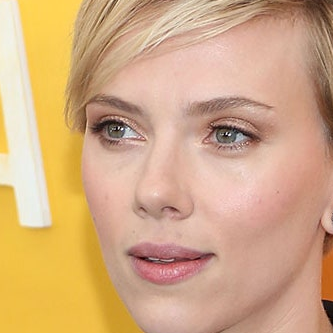

In [77]:
output(r"/content/isQ747u0MU8U9gdsNlPngjABclH.jpg")

1/1 [==============================] - 0s 59ms/step


'mark_ruffalo'

In [ ]:
img = cv2.imread("/content/isQ747u0MU8U9gdsNlPngjABclH.jpg")
img

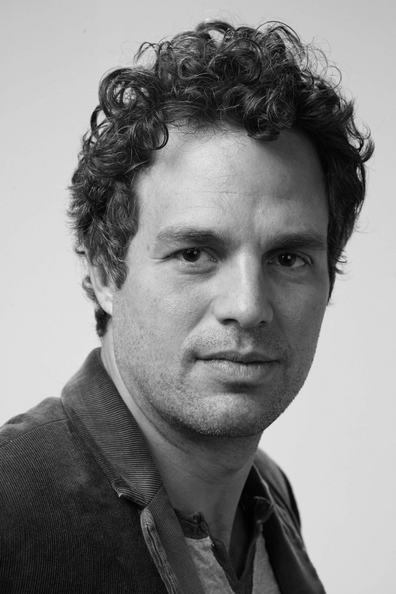

In [89]:
# Converting the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# plot_image(gray, cmap='gray')
gyay1 = cv2.imwrite("mark_Ruffola.png",gray)
gray = load_img("/content/mark_Ruffola.png")
gray